# Lab 10 - Linear Models

In [1]:
%matplotlib inline

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

### General Instructions

1.  You will be submitting your assignment to Blackboard. If there are no accompanying files, you should submit *only* your notebook and it should be named using *only* your JHED id: fsmith79.ipynb for example if your JHED id were "fsmith79". If the assignment requires additional files, you should name the *folder/directory* your JHED id and put all items in that folder/directory, ZIP it up (only ZIP...no other compression), and submit it to Blackboard.
    
    * do **not** use absolute paths in your notebooks. All resources should appear in the same directory as the rest of your assignments.
    * the directory **must** be named your JHED id and **only** your JHED id.
    
2. Data Science is as much about what you write (communicating) as the code you execute (researching). In many places, you will be required to execute code and discuss both the purpose and the result. Additionally, Data Science is about reproducibility and transparency. This includes good communication with your team and possibly with yourself. Therefore, you must show **all** work.

3. Avail yourself of the Markdown/Codecell nature of the notebook. If you don't know about Markdown, look it up. Your notebooks should not look like ransom notes. Don't make everything bold. Clearly indicate what question you are answering.

4. Submit a cleanly executed notebook. It should say `In [1]` for the first codecell and increase by 1 throughout.

## Linear Regression

In a previous module (Lab 5), you performed EDA on the insurance data set. In this Lab, you should build a linear regression model trying to estimate `charges`.

In [2]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

sns.set(style="whitegrid")

In [3]:
import models

# Answer

Let's start by reading in the data and looking at the variables we have in the dataframe.

In [4]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv", header=0)

In [4]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


So we have 6 variables not including our target variable. We can view their types as well.

In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We see no missing entries, age and children are numeric, as is bmi but technically is a float. Smoker and sex are binary categorical variables, and region is categorical with 4 values (from our previous EDA analysis). Let's take a quick look at region again.

In [6]:
insurance['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

We'll first start by converting the categorical variables into a one hot encoding. We'll look at transforming region first.

In [5]:
regions = insurance['region'].unique()
region = {'region': ['southeast', 'southwest', 'northwest', 'northeast' ]}
data = pd.DataFrame(region)

insurance = pd.concat([insurance, pd.get_dummies(insurance['region'])], axis=1)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,False,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,False,False,True,False
2,28,male,33.000,3,no,southeast,4449.46200,False,False,True,False
3,33,male,22.705,0,no,northwest,21984.47061,False,True,False,False
4,32,male,28.880,0,no,northwest,3866.85520,False,True,False,False


Looks pretty good. Now we can do a similar transformation for sex and smoker. We'll make sure the transformations don't cause unexpected changes.

In [21]:
pd.DataFrame(insurance['sex'].value_counts())

,count
sex,
male,676
female,662


In [6]:
insurance['female'] = insurance['sex'].apply(lambda x: 1 if x == 'female' else 0)

pd.DataFrame(insurance['female'].value_counts())

,count
female,
0,676
1,662


Look like we have the same value counts after the encoding. We can apply the same thing for smoker.

In [23]:
pd.DataFrame(insurance['smoker'].value_counts())

,count
smoker,
no,1064
yes,274


In [7]:
insurance['smokes'] = insurance['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

pd.DataFrame(insurance['smokes'].value_counts())

,count
smokes,
0,1064
1,274


Looks good. For putting our encoded variables in our regression model, we are leaving out one value of the encodings. For region, we will leave out southeast, for sex we will leave out male, and for smoker we will leave out no.

In [43]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest,female,smokes
0,19,female,27.900,0,yes,southwest,16884.92400,False,False,False,True,1,1
1,18,male,33.770,1,no,southeast,1725.55230,False,False,True,False,0,0
2,28,male,33.000,3,no,southeast,4449.46200,False,False,True,False,0,0
3,33,male,22.705,0,no,northwest,21984.47061,False,True,False,False,0,0
4,32,male,28.880,0,no,northwest,3866.85520,False,True,False,False,0,0


Here we just see all our encodings should be present in our dataframe.

Before we create our model, we can think about how each variable could affect charges (note we've already seen the pairwise EDA, so I will just summarize here):
<ul>
    <li> age - positive most likely, as age increases, so do health issues
    <li> bmi - positive, charges would increase for obese people
    <li> children - positive, as number of children increase, charges are more costly
    <li> northeast - ? we don't have enough to go on here, possibly positive if there are higher population centers in the northeast
    <li> northwest - again we don't know
    <li> southwest - let's guess negative, just to oppose the north
    <li> female - negative, women tend to have higher life expectancy than men
    <li> smokes - positive, we know from EDA that smoking largely increases charges

<ul>

Let's start with the all variables in model:

In [8]:
model = '''charges ~ age + bmi + children + northeast
        + northwest + southwest + female + smokes'''

result = models.bootstrap_linear_regression(model, data=insurance)

In [9]:
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-13104.87,-15537.73,-11225.83
age,$\beta_{1}$,1035.02,55.72,2289.19
bmi,$\beta_{2}$,682.06,-95.34,1741.94
children,$\beta_{3}$,74.97,-854.02,1056.09
northeast,$\beta_{4}$,256.86,230.93,280.22
northwest,$\beta_{5}$,339.19,286.08,405.66
southwest,$\beta_{6}$,475.50,201.12,805.35
female,$\beta_{7}$,131.31,-429.73,754.17
smokes,$\beta_{8}$,23848.53,22620.00,24801.99


We see the $R^2$ is 0.75, so the model explains 75% of the variability in charges. We should also look at the adjusted $R^2$ since we have so many variables in the model. I will copy the `adjusted_r_squared` function from *Fundamentals, page 779*.

In [10]:
def adjusted_r_squared(result):
    adjustment = (result['n'] - 1)/ (result['n'] - len(result['coefficients']) - 1 - 1)
    return 1 - (1 - result['r_squared']) * adjustment

In [11]:
adjusted_r_squared(result)

0.7490359662835133

We see about the same result here, but note the adjusted R squared could be handy to look at as we proceed to refine our model.

Let's describe our initial charges category as a reminder

In [49]:
insurance['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

We see a std of 12,110, while our $\sigma$ is 6062.10, almost half. Coefficients aare all positive, but only charges hugely so. Aside from region, the other variable credible intervals contain 0. We can look at our strong/weak/mixed our evidence is that we predicted these variables correctly

In [12]:
predictions = {'age': '+', 'bmi': '+', 'children': '+', 'northeast': '+',
            'northwest': '+', 'southwest': '-', 'female': '-', 'smokes': '+'}

models.evaluate_coefficient_predictions(predictions, result)

age P(>0)=0.980 (strong)
bmi P(>0)=0.960 (strong)
children P(>0)=0.590 (mixed)
northeast P(>0)=1.000 (strong)
northwest P(>0)=1.000 (strong)
southwest P(<0)=0.000 (weak)
female P(<0)=0.330 (weak)
smokes P(>0)=1.000 (strong)


We have strong evidence that age, bmi, northeast, northwest, and smokes are all positive. Weak evidence that southwest is negative, but we weren't really positive (heh), and then mixed results for children and female. From our EDA, we saw men and women didn't have much of a difference in charges, and we had a weak correlation between number of children and charges.

According to our table for evaluating coefficients, we should remove variables that had an unexpected sign and includes 0 - female falls into that category, so I will take it out of the model (we should not expect to see much of a difference between men and women anyway based on our EDA).

Let's try a model without the female variable

In [14]:
model = '''charges ~ age + bmi + children + northeast
        + northwest + southwest + smokes'''

result = models.bootstrap_linear_regression(model, data=insurance)

models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-13024.63,-15056.66,-10600.09
age,$\beta_{1}$,1034.36,-69.29,2013.98
bmi,$\beta_{2}$,682.18,-387.08,1783.37
children,$\beta_{3}$,74.99,-900.33,988.41
northeast,$\beta_{4}$,256.97,238.93,277.67
northwest,$\beta_{5}$,338.66,272.89,384.75
southwest,$\beta_{6}$,474.57,247.61,683.33
smokes,$\beta_{7}$,23836.30,22955.23,24866.49
,,,,


We have the same $R^2$ value of 0.75 and a very similar, slightly smaller $\sigma$ of 6060. This likely means the female variable does not contribute much to the overall model, and is thus fine to exclude.

Our coefficients and credible intervals are mostly the same as well.

Next we can look at residuals for each variable in the model 

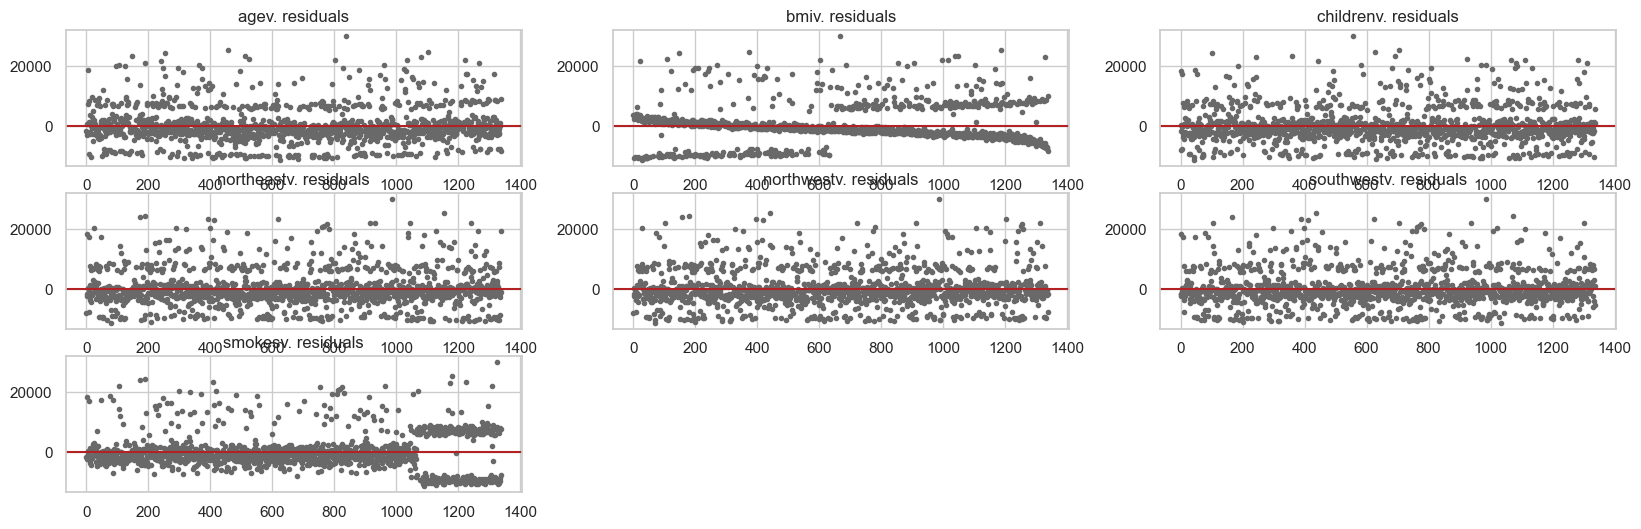

In [15]:
figure = plt.figure(figsize=(20,6))

variables = ['age', 'bmi', 'children', 'northeast', 'northwest', 'southwest', 'smokes']

plots = len(variables)
rows = (plots // 3) + 1

for i, variable in enumerate(variables):
    axes = figure.add_subplot(rows, 3, i+1)

    keyed_values = sorted(zip(insurance[variable].values, result['residuals']),
                            key=lambda x: x[0])
    residuals = [x[1][0] for x in keyed_values]

    axes.plot(list(range(0, result['n'])), residuals, '.', color='dimgray')
    axes.axhline(y=0.0, xmin=0, xmax=result['n'], c='firebrick')
    axes.set_title(variable + 'v. residuals')

plt.show()
plt.close()


Definitely not ideal. Bmi shows almost a mirrored residual plot, while smokes shows higher variability for larger values. I could make an argument for the other variables being 'okay', but it is a little subjective here.

Our next step would be to attempt a transformation of the variables. For bmi in particular, I think we could try a square root transformation.

In [16]:
insurance['bmi_sqrt'] = insurance['bmi'] ** 0.5



In [17]:
model = '''charges ~ age + bmi_sqrt + children + northeast
        + northwest + southwest + smokes'''

result = models.bootstrap_linear_regression(model, data=insurance)

models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-23367.69,-26557.95,-19240.83
age,$\beta_{1}$,1031.63,69.53,1837.20
bmi_sqrt,$\beta_{2}$,653.40,-490.94,1654.74
children,$\beta_{3}$,49.00,-831.03,892.19
northeast,$\beta_{4}$,256.33,236.43,278.36
northwest,$\beta_{5}$,3768.69,3067.63,4363.14
southwest,$\beta_{6}$,474.89,221.99,707.87
smokes,$\beta_{7}$,23842.20,22691.08,24703.54
,,,,


Hmm so we don't see much of a change here. We might try then to perform a log transform instead

In [20]:
insurance['bmi_log'] = np.log((insurance['bmi']))

Now let's try the model again

In [23]:
model = '''charges ~ age + bmi_log + children + northeast
        + northwest + southwest + smokes'''

result = models.bootstrap_linear_regression(model, data=insurance)

models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-37501.85,-44325.67,-31166.26
age,$\beta_{1}$,1014.43,-161.76,1809.38
bmi_log,$\beta_{2}$,609.45,-295.99,1510.79
children,$\beta_{3}$,13.70,-974.90,844.80
northeast,$\beta_{4}$,255.87,230.91,283.66
northwest,$\beta_{5}$,10267.33,8392.80,12229.96
southwest,$\beta_{6}$,475.38,203.74,712.64
smokes,$\beta_{7}$,23847.42,22912.41,24915.71
,,,,


Again not much of a difference here. I think overall there are too many variables in this model. Reducing the number of variables would perhaps be best. From our EDA, we know that region does not appear to have a huge effect on charges. We could consider either removing those variables or maybe combining them in some way.

Let's try a model without the region variables just for fun

In [27]:
model = '''charges ~ age + bmi_log + children
        + smokes'''

result = models.bootstrap_linear_regression(model, data=insurance)

models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-35521.06,-41875.32,-30059.11
age,$\beta_{1}$,256.73,232.58,277.65
bmi_log,$\beta_{2}$,9793.93,8229.78,11609.71
children,$\beta_{3}$,473.31,170.48,687.02
smokes,$\beta_{4}$,23826.87,22784.72,24878.37
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,6061.68,5726.97,6329.99,
$R^2$,0.75,0.72,0.78,


This does not improve the model at all, but also does not make it worse. I'm not really sure where to go from here, it seems like any transformation or removal or variables does not improve the model in any significant way.

From EDA, we saw that age is sort of split into 3 subgroups, and so we might try to discretize this variable by turning into a categorical one and create a one hot encoding. Overall we know that most of the variation in the model comes from the smokes variable, as evident below

In [31]:
model = '''charges ~ smokes
        '''

result = models.bootstrap_linear_regression(model, data=insurance)

models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,8434.27,8139.23,8810.55
smokes,$\beta_{1}$,23615.96,22213.25,24730.80
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,7470.22,7115.67,7887.02,
$R^2$,0.62,0.58,0.65,


But let's try changing age first and see how that model performs.

In [42]:
from tabulate import tabulate

In [57]:
middle = insurance[(insurance['age'] >= 30) & (insurance['age'] < 50)]


In [61]:
young = len(insurance[insurance['age'] < 30])
middle = len(insurance[(insurance['age'] >= 30) & (insurance['age'] < 50)])
old = len(insurance[insurance['age'] >= 50])

tabulate([[young], [middle], [old]], tablefmt='html')

417
536
385


In [66]:
insurance['age_group'] = insurance['age'].apply(lambda x: 'young' if x < 30 else ('middle' if x < 50 else 'old'))

pd.DataFrame(insurance['age_group'].value_counts().sort_index())

,count
age_group,
middle,536
old,385
young,417


Our data was transformed correctly. We will leave the young group out of the model. Let's check we have our dummies in the dataframe

In [67]:
insurance = pd.concat([insurance, pd.get_dummies(insurance['age_group'])], axis=1)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,...,smokes,bmi_sqrt,bmi_log,age_group,0,1,2,middle,old,young
0,19,female,27.900,0,yes,southwest,16884.92400,False,False,False,...,1,5.282045,3.328627,young,True,False,False,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,False,False,True,...,0,5.811196,3.519573,young,True,False,False,False,False,True
2,28,male,33.000,3,no,southeast,4449.46200,False,False,True,...,0,5.744563,3.496508,young,True,False,False,False,False,True
3,33,male,22.705,0,no,northwest,21984.47061,False,True,False,...,0,4.764976,3.122585,middle,False,True,False,True,False,False
4,32,male,28.880,0,no,northwest,3866.85520,False,True,False,...,0,5.374012,3.363149,middle,False,True,False,True,False,False


Good enough. Let's try a model

In [70]:
model = '''charges ~ middle + old + bmi_log + children
        + smokes'''

result = models.bootstrap_linear_regression(model, data=insurance)

models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-29385.91,-34804.00,-23989.17
middle,$\beta_{1}$,2840.17,2018.03,3797.51
old,$\beta_{2}$,8734.03,7875.79,9530.72
bmi_log,$\beta_{3}$,9823.00,8277.98,11346.63
children,$\beta_{4}$,624.48,299.92,848.09
smokes,$\beta_{5}$,23901.00,22894.36,24885.88
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,6156.67,5753.20,6452.39,


Not much has changed from our intial model. We can look at the residuals as well.

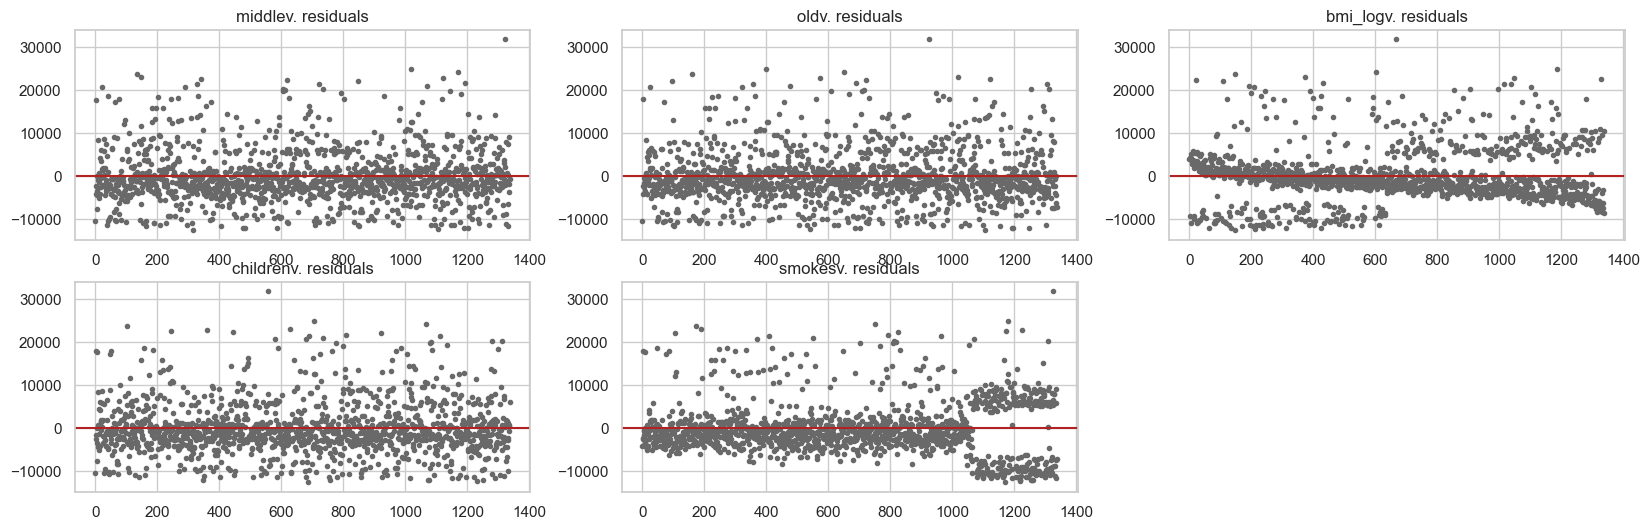

In [69]:
figure = plt.figure(figsize=(20,6))

variables = ['middle', 'old', 'bmi_log', 'children', 'smokes']

plots = len(variables)
rows = (plots // 3) + 1

for i, variable in enumerate(variables):
    axes = figure.add_subplot(rows, 3, i+1)

    keyed_values = sorted(zip(insurance[variable].values, result['residuals']),
                            key=lambda x: x[0])
    residuals = [x[1][0] for x in keyed_values]

    axes.plot(list(range(0, result['n'])), residuals, '.', color='dimgray')
    axes.axhline(y=0.0, xmin=0, xmax=result['n'], c='firebrick')
    axes.set_title(variable + 'v. residuals')

plt.show()
plt.close()

Again bmi_log and smokes have some patterns to them, but at this point I'm not sure how to properly transform these variables.

### Conclusion

We know from EDA that smoker has the largest effect on charges. All other variables produce a much smaller effect, in terms of the regression model. We know that sex and region do not produce large effects, and don't reduce the model predictability, and so may not be worth including in the model.

We tried transforming bmi in order to make the residuals more symmetric, which did not help a ton. There are only so many transformations, but it doesn't seem like any would help. We could consider discretizing the variable similar to what we did with age.

Smokes variable also has a pattern in its residual plot, but since it is a binary categorical variable, we cannot easily perform mathematical transformations on this variable.

Comparing all the models we've seen, the 'best' one was the one with the bmi square root transformation, but really not by much, it has a slightly smaller $\sigma$ but the same $R^2$ as what we've seen in the other models. At this point, we could simply perform a simple regression on just the smoking variable and that might be sufficient for our needs.